# A practice toy proyect to solving linear differential equations using Hybrid Classical-Quantum algorithms.

# Based on arXiv:2011.10395v2 to be done in Qiskit.

In [2]:
# Initialisation in Python

import numpy as np # Python library used for working with arrays.
from numpy import pi # Value of pi.
import matplotlib.pyplot as plt # Library for data visualization (plots and others). Alternative to MATLAB.
from scipy.integrate import odeint # Collection of numerical algorithms to solve ordinary differential equations. 
import random # Generate random numbers.

In [3]:
# Quantum computing library initialisation: Qiskit (Vendor: IBM)

from qiskit import * # Imports all the functions and classes.
from qiskit import BasicAer # Give access some of the basic simulators.
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter, QuantumRegister, ClassicalRegister
# Define a quantum circuit,quickly generate lists of parameters, define a register of qubits and the classical analog.
from qiskit.circuit.library import PauliFeatureMap # Feature maps already in Qiskit. Just to test.
from qiskit.circuit.library import EfficientSU2
# Circuit with layers of single qubit operations spanned by SU(2). It can be used to prepare trial wave functions for VQA.
from qiskit.algorithms.optimizers import ADAM # Adam is a gradient-based optimization algorithm.
# According to the documentation "numerical optimization method for problems where the derivative of the function is not known".
from qiskit.utils import QuantumInstance # It "holds a backend as well as configuration for circuit transpilation and execution".
from qiskit.utils import algorithm_globals # Just in case. Most include the optimizers.
from qiskit.visualization import circuit_drawer # As the name say.
from qiskit.opflow import X, Y, Z, I, StateFn, CircuitStateFn, PauliExpectation
# "Operators and State functions are the building blocks of Quantum Algorithms"
from qiskit.opflow.gradients import Gradient# A very use way to minnimize functions is using gradients.


num_qubits = 2 # 2 qubits.

In [4]:
# Initialisation: ML with Qiskit

from qiskit_machine_learning.kernels import QuantumKernel # "It calculates a kernel matrix, given datapoints x and y and feature map..."
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer #  To train the kernel parameters on the dataset.
from qiskit_machine_learning.datasets import ad_hoc_data # Just in case. Generates a toy dataset that can be fully separated with ZZ_Feature_Map.
from qiskit_machine_learning.neural_networks import OpflowQNN # Opflow Quantum Neural Network.

from qiskit.providers.aer import AerSimulator # Just in case. Variety of simulation methods.

# We will try to implement the model for the simple differential equation:

$\dfrac{df(x)}{dx} = -kf(x) $,

with parameter $k=0.3$ and the initial condition $f_{0}=5$. In the domain [-1;1].

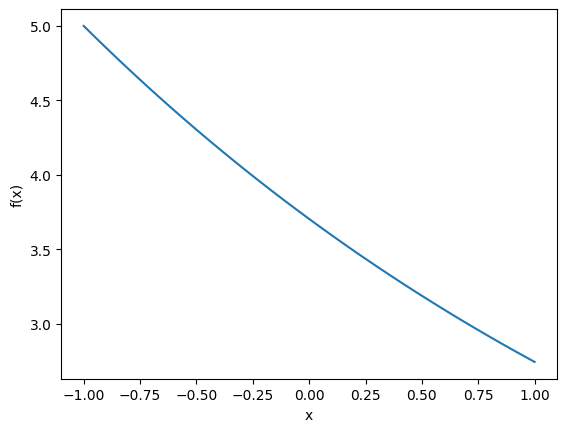

In [14]:
# Differential equation parameters

from scipy.integrate import odeint

def model(f,x): # Function that returns df/dx
    k = 0.3
    dfdx = -k * f
    return dfdx

x = np.linspace(-1, 1) # X points in the domain
f0 = 5 # Initial condition
sol = odeint(model, f0, x)

# Exact DE solution - for checking after
def f(x):
    return -k*(x**2)/2

# Traditional plot
plt.plot(x,sol)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [15]:
number_grid = 15  # Number of grid points of the discretized differential equation - trainning   
range_min = -1 # Minimum of the interval on which the function lives.
range_max = 1 # Maximum of the interval on which the function lives.
TrialX = np.linspace(range_min, range_max, number_grid) # Optimisation grid

print(TrialX)

[-1.         -0.85714286 -0.71428571 -0.57142857 -0.42857143 -0.28571429
 -0.14285714  0.          0.14285714  0.28571429  0.42857143  0.57142857
  0.71428571  0.85714286  1.        ]


In [16]:
number_grid = 50  # Number of grid points of the discretized differential equation - testing     
TrialTest = np.linspace(range_min, range_max, number_grid) 

print(TrialTest)

[-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469 -0.79591837
 -0.75510204 -0.71428571 -0.67346939 -0.63265306 -0.59183673 -0.55102041
 -0.51020408 -0.46938776 -0.42857143 -0.3877551  -0.34693878 -0.30612245
 -0.26530612 -0.2244898  -0.18367347 -0.14285714 -0.10204082 -0.06122449
 -0.02040816  0.02040816  0.06122449  0.10204082  0.14285714  0.18367347
  0.2244898   0.26530612  0.30612245  0.34693878  0.3877551   0.42857143
  0.46938776  0.51020408  0.55102041  0.59183673  0.63265306  0.67346939
  0.71428571  0.75510204  0.79591837  0.83673469  0.87755102  0.91836735
  0.95918367  1.        ]


In [7]:
# Numerical differentiation of f
#dx = (range_max-range_min) / number_grid

In [8]:
# Basic statevector simulator

backend = BasicAer.get_backend('statevector_simulator') # "Executes a single shot of a QuantumCircuit and returns the quantum statevector"
random_seed = 10599

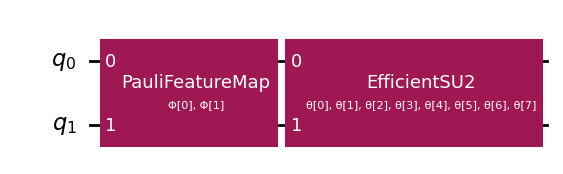

In [9]:
# Definition of the circuit:
# We need a Feature map to encode the data, an Ansatz to train and a observable to evaluate

# Construct feature map (module to transform the data to feature space), ansatz, and optimizer

feature_dim = 2 # Number of qubits in the circuit

feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='linear', paulis = ['X'],parameter_prefix='Φ')
# Linear: entangles each qubit with the next.
# Reps: repetitions of this transformation.
#feature_map.draw()

ansatz = EfficientSU2(feature_dim, reps=1)
#ansatz.draw()
# "EfficientSU2 consists of layers of single qubit operations spanned by SU(2) and CX entanglements".

seed = 10599
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

circuit = feature_map.compose(ansatz) # Putting the circuit together.
circuit.draw('mpl',style='iqx')

In [10]:
# Define cost-function
# According to article "The simplest example corresponds to the magnetization of a single qubit j, <Zj>."
# "[...] this choice allows representing functions in range [-1; 1]."

cost_function = Z

In [11]:
# Construct operator for measurement of expectation value of the final model circuit.

expectation = StateFn(cost_function, is_measurement=True) @ StateFn(ansatz)

In [12]:
# Construct [toy] loss function

#def loss_function(weight,observable):
 #   loss = 
  #  return loss

In [20]:
# Let's get the gradient:

test = Gradient()
#shifter = Gradient(expectation, grad_method = 'fin_diff')